In [179]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
from loader import load_data
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)

In [180]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [181]:
df = load_data(r"D:\misc\code\bayesian_retry\data_hockey")
df = df.loc[df.Resultat != " -:-"]
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,Id,Liga,Region,Phase,TV/Online
0,Mi,09.09.2015,19:45,ZSC Lions,SC Bern,5:3,1:0|2:3|2:0,NaN,Ende,False,"Hallenstadion AG, Zürich",9038,20161105071114,NL A,CH,Regular Season,NaN
1,Fr,11.09.2015,19:45,SC Bern,SCL Tigers,7:1,1:0|4:1|2:0,NaN,Ende,False,"PostFinance-Arena, Bern",17031,20161105071001,NL A,CH,Regular Season,NaN
2,Fr,11.09.2015,19:45,HC Davos,Fribourg-Gottéron,4:5,1:0|1:3|2:1|0:1,SO,Ende,False,"Vaillant Arena, Davos",4488,20161105071002,NL A,CH,Regular Season,NaN
3,Fr,11.09.2015,19:45,Genève-Servette HC,HC Ambri-Piotta,8:2,1:2|4:0|3:0,NaN,Ende,False,"Les Vernets, Genève",5804,20161105071003,NL A,CH,Regular Season,NaN
4,Fr,11.09.2015,19:45,EHC Kloten,EHC Biel-Bienne,3:7,2:1|0:3|1:3,NaN,Ende,False,"SWISS Arena, Kloten",4152,20161105071004,NL A,CH,Regular Season,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000413,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2454,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000414,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2455,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000415,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2456,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000416,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"


# Preprocessing and data exploration

In [182]:
# create a dictionary to store the points for each team
points_dict = {}
team_tot_points = {}

# iterate over each row in the dataframe
for index, row in df.iterrows():
    # extract the team names
    home_team = row['Home']
    away_team = row['Away']
    
    # extract the result for the home and away team
    home_result = row['Resultat'].split(':')[0].strip()
    away_result = row['Resultat'].split(':')[1].strip()
    
    # add points to the home team
    if home_team not in team_tot_points:
        team_tot_points[home_team] = {'points': 0}
    if home_team not in points_dict:
        points_dict[home_team] = {'total': 0, 'home': 0, 'away': 0}
    # add to total points column
    team_tot_points[home_team]['points'] += int(home_result)
    points_dict[home_team]['total'] += int(home_result)
    points_dict[home_team]['home'] += int(home_result)
    # add to specific team column
    points_dict[home_team][away_team+' (away)'] = points_dict[home_team].get(away_team+' (away)', 0) + int(away_result)
    
    # add points to the away team
    if away_team not in team_tot_points:
        team_tot_points[away_team] = {'points': 0}
    if away_team not in points_dict:
        points_dict[away_team] = {'total': 0, 'home': 0, 'away': 0}
    team_tot_points[away_team]['points'] += int(away_result)
    points_dict[away_team]['total'] += int(away_result)
    points_dict[away_team]['away'] += int(away_result)
    points_dict[away_team][home_team+' (home)'] = points_dict[away_team].get(home_team+' (home)', 0) + int(home_result)

# create a new dataframe from the points_dict
tot_points_df = pd.DataFrame.from_dict(team_tot_points, orient='index')
partial_points_df = pd.DataFrame.from_dict(points_dict, orient='index')
points_df = pd.concat([tot_points_df, partial_points_df], axis=1)


In [183]:
# extract columns with "Points", "Home", and "Away" in their names
point_cols = [col for col in points_df.columns if "Points" in col]
home_cols = [col for col in points_df.columns if "Home" in col]
away_cols = [col for col in points_df.columns if "Away" in col]

# concatenate the columns into a new list
sorted_cols = point_cols + home_cols + away_cols + sorted([col for col in points_df.columns if col not in point_cols+home_cols+away_cols])

# sort the columns in the DataFrame
points_df = points_df[sorted_cols]

In [184]:
# Define the column order you want
cols = ['away', 'home', 'points', 'total'] + sorted([col for col in points_df.columns if col not in ['away', 'home', 'points', 'total']])

# Reorder the columns
points_df = points_df.reindex(columns=cols)

# Show the resulting dataframe
points_df

,away,home,points,total,EHC Biel-Bienne (away),EHC Biel-Bienne (home),EHC Kloten (away),EHC Kloten (home),EV Zug (away),EV Zug (home),...,SC Bern (away),SC Bern (home),SC Langenthal (away),SC Langenthal (home),SC Rapperswil-Jona Lakers (away),SC Rapperswil-Jona Lakers (home),SCL Tigers (away),SCL Tigers (home),ZSC Lions (away),ZSC Lions (home)
EHC Biel-Bienne,520,631,1151,1151,NaN,NaN,19.0,20.0,43.0,57.0,...,64.0,65.0,NaN,NaN,12.0,28.0,42.0,56.0,62.0,59.0
EHC Kloten,223,248,471,471,23.0,18.0,NaN,NaN,24.0,23.0,...,16.0,25.0,NaN,NaN,11.0,6.0,33.0,32.0,30.0,23.0
EV Zug,614,737,1351,1351,42.0,39.0,17.0,15.0,NaN,NaN,...,56.0,75.0,NaN,NaN,19.0,26.0,28.0,50.0,62.0,64.0
Fribourg-Gottéron,482,604,1086,1086,37.0,42.0,17.0,12.0,49.0,44.0,...,50.0,52.0,NaN,NaN,19.0,33.0,34.0,34.0,44.0,56.0
Genève-Servette HC,512,606,1118,1118,42.0,67.0,16.0,13.0,47.0,61.0,...,57.0,82.0,NaN,NaN,14.0,20.0,38.0,30.0,37.0,44.0
HC Ajoie,36,53,89,89,7.0,11.0,NaN,NaN,8.0,13.0,...,8.0,8.0,NaN,NaN,12.0,14.0,3.0,17.0,10.0,13.0
HC Ambri-Piotta,456,536,992,992,43.0,68.0,27.0,29.0,59.0,80.0,...,43.0,47.0,3.0,1.0,30.0,33.0,43.0,45.0,42.0,51.0
HC Davos,588,624,1212,1212,48.0,54.0,19.0,29.0,67.0,77.0,...,52.0,46.0,NaN,NaN,42.0,47.0,46.0,35.0,48.0,57.0
HC Lugano,542,691,1233,1233,48.0,71.0,18.0,26.0,84.0,91.0,...,43.0,51.0,NaN,NaN,28.0,31.0,35.0,40.0,45.0,77.0
Lausanne HC,497,630,1127,1127,45.0,51.0,9.0,22.0,35.0,57.0,...,46.0,55.0,NaN,NaN,18.0,31.0,49.0,38.0,46.0,54.0


In [185]:
# def winner(home, away):
#     if home>away:
#         return "H"
#     else:
#         return "A"

In [186]:
# # clean the data
# df = df.loc[df.Resultat != " -:-"]

# # reformat the data
# df = df[['Home', 'Away', 'Resultat', 'Datum']]
# df[['result_home', 'result_away']] = df['Resultat'].str.split(':', expand=True)
# df['result_home'] = df['result_home'].astype(int)
# df['result_away'] = df['result_away'].astype(int)
# df = df.drop("Resultat", axis=1)
# df.reset_index(drop=True)

# df['Winner'] = df.apply(lambda x: winner(x['result_home'], x['result_away']), axis=1)

# # Home games
# df_lugano = df[df['Home'] == "HC Lugano"]
# df_lugano['Win'] = df_lugano['Winner'] == "H"
# df_lugano['Place'] = 0
# df_lugano['Difference'] = df_lugano['result_home']- df_lugano['result_away']
# df_lugano = df_lugano.drop(['Home','Winner', 'result_home', 'result_away'], axis=1)
# df_lugano.columns = ['Opponent','Date', 'Win', 'Place', 'Difference']

# # Away games
# df_lugano_out = df[df['Away'] == "HC Lugano"]
# df_lugano_out['Win'] = df_lugano_out['Winner'] == "A"
# df_lugano_out['Place'] = 1
# df_lugano_out['Difference'] = df_lugano_out['result_away']- df_lugano_out['result_home']
# df_lugano_out = df_lugano_out.drop(['Away','Winner', 'result_home', 'result_away'], axis=1)
# df_lugano_out.columns = ['Opponent','Date', 'Win', 'Place', 'Difference']

# # Final merge
# df = pd.concat([df_lugano, df_lugano_out]).reset_index(drop=True)
# df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# df = df.sort_values(by='Date',ascending=True)

# df['Rest_days'] = df["Date"].diff()

# df = df.dropna().reset_index(drop=True)
# df['Rest_days'] = df['Rest_days'].apply(lambda x: x.days)
# df

In [187]:
# select HC Lugano, HC Ambri-Piotta for our first hypotheses test.
df_1 = points_df[points_df.index.isin(['HC Lugano', 'HC Ambri-Piotta'])]
df_1

,away,home,points,total,EHC Biel-Bienne (away),EHC Biel-Bienne (home),EHC Kloten (away),EHC Kloten (home),EV Zug (away),EV Zug (home),...,SC Bern (away),SC Bern (home),SC Langenthal (away),SC Langenthal (home),SC Rapperswil-Jona Lakers (away),SC Rapperswil-Jona Lakers (home),SCL Tigers (away),SCL Tigers (home),ZSC Lions (away),ZSC Lions (home)
HC Ambri-Piotta,456,536,992,992,43.0,68.0,27.0,29.0,59.0,80.0,...,43.0,47.0,3.0,1.0,30.0,33.0,43.0,45.0,42.0,51.0
HC Lugano,542,691,1233,1233,48.0,71.0,18.0,26.0,84.0,91.0,...,43.0,51.0,NaN,NaN,28.0,31.0,35.0,40.0,45.0,77.0


In [188]:
# cast to float numpy arrays for pymc3
points_hcl = df_1.iloc[0, 4:].values
points_hcap = df_1.iloc[1, 4:].values
points_hcl = np.array(points_hcl, dtype=float)
points_hcap = np.array(points_hcap, dtype=float)

In [189]:
points_hcl

array([43., 68., 27., 29., 59., 80., 35., 60., 32., 53.,  2.,  5., nan,
       nan, 50., 62., 55., 87., 44., 57., 43., 47.,  3.,  1., 30., 33.,
       43., 45., 42., 51.])

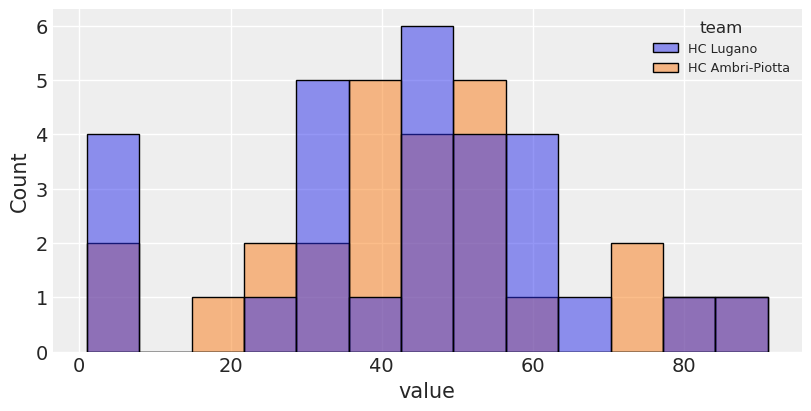

In [190]:
y  = pd.DataFrame(dict(value=np.r_[points_hcl, points_hcap], team=np.r_[["HC Lugano"]*len(points_hcl), ['HC Ambri-Piotta']*len(points_hcap)]))
sns.histplot(data=y, x="value", hue="team", bins=13);